   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other             C3       

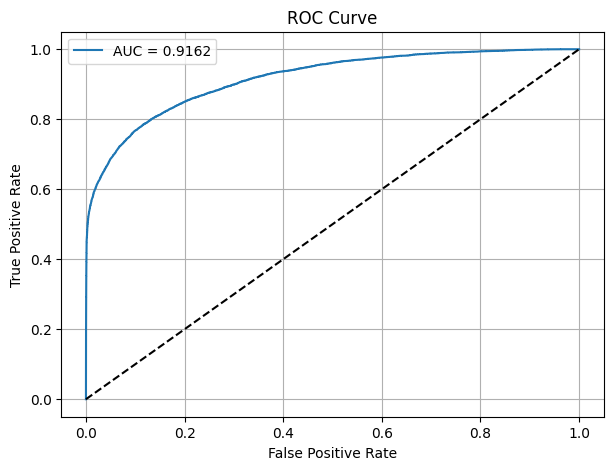


Best Threshold: 0.36
Best F1: 0.7288160541680977

=== EDUCATION LEVEL PERFORMANCE ===
  education_level  n_samples       AUC  Accuracy  Precision    Recall  \
4             PhD        994  0.924602  0.911469   0.777778  0.687861   
0      Bachelor's      25272  0.918309  0.894785   0.776280  0.697652   
3           Other       2423  0.916251  0.892695   0.806147  0.657033   
1     High School      16455  0.915161  0.899848   0.769946  0.681660   
2        Master's       8479  0.910929  0.897158   0.777166  0.673421   

         F1  
4  0.730061  
0  0.734869  
3  0.723992  
1  0.723118  
2  0.721584  

=== LOAN PURPOSE PERFORMANCE ===
         loan_purpose  n_samples       AUC  Accuracy  Precision    Recall  \
3           Education       3240  0.929881  0.902469   0.821604  0.708039   
7            Vacation        759  0.920018  0.891963   0.755556  0.675497   
1                 Car       5250  0.918844  0.897714   0.756699  0.694882   
6               Other       5807  0.916352  0.89

In [4]:
# ==========================================
#   FinSecure Loan Default Prediction Model
#   FAST COMPLETE SCRIPT (NO GRIDSEARCH)
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, precision_score,
    recall_score, f1_score
)

# ==========================================
# 1. Load Data
# ==========================================

df = pd.read_csv(r"C:\Users\JAI MATA DI\Downloads\loan_data.csv")
print(df.head())
print(df.columns)

# ==========================================
# 2. Define Target (default)
# ==========================================

df["default"] = 1 - df["loan_paid_back"]

X = df.drop(columns=["id", "loan_paid_back", "default"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 3. Preprocessing Pipelines
# ==========================================

numeric_features = ["annual_income", "debt_to_income_ratio",
                    "credit_score", "loan_amount", "interest_rate"]

categorical_features = ["gender", "marital_status", "education_level",
                        "employment_status", "loan_purpose", "grade_subgrade"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# ==========================================
# 4. Baseline Logistic Regression
# ==========================================

log_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_clf.fit(X_train, y_train)
log_proba = log_clf.predict_proba(X_test)[:, 1]
print("\nBaseline Logistic Regression AUC:", roc_auc_score(y_test, log_proba))

# ==========================================
# 5. FAST Gradient Boosting (NO GRIDSEARCH)
# ==========================================

best_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

print("\nTraining fast Gradient Boosting model...")
best_model.fit(X_train, y_train)

y_test_proba = best_model.predict_proba(X_test)[:, 1]
print("Fast Model Test AUC:", roc_auc_score(y_test, y_test_proba))

# ==========================================
# 6. ROC Curve
# ==========================================

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label="AUC = %.4f" % roc_auc)
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# ==========================================
# 7. Optimal Threshold (Max F1)
# ==========================================

thresholds = np.linspace(0.1, 0.9, 81)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    preds = (y_test_proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nBest Threshold:", best_threshold)
print("Best F1:", best_f1)

y_test_pred = (y_test_proba >= best_threshold).astype(int)

# ==========================================
# 8. Attach Predictions to Test Set
# ==========================================

X_test_eval = X_test.copy()
X_test_eval["default"] = y_test.values
X_test_eval["pred_proba"] = y_test_proba
X_test_eval["pred_label"] = y_test_pred

# ==========================================
# 9. Subgroup Analysis Function
# ==========================================

def group_metrics(df, col):
    rows = []
    for group, g in df.groupby(col):
        if g["default"].nunique() < 2:
            auc_val = None
        else:
            auc_val = roc_auc_score(g["default"], g["pred_proba"])
        
        rows.append({
            col: group,
            "n_samples": len(g),
            "AUC": auc_val,
            "Accuracy": accuracy_score(g["default"], g["pred_label"]),
            "Precision": precision_score(g["default"], g["pred_label"], zero_division=0),
            "Recall": recall_score(g["default"], g["pred_label"]),
            "F1": f1_score(g["default"], g["pred_label"])
        })
    return pd.DataFrame(rows)

# ==========================================
# 10. Education Level Subgroup Analysis
# ==========================================

edu_results = group_metrics(X_test_eval, "education_level")
print("\n=== EDUCATION LEVEL PERFORMANCE ===")
print(edu_results.sort_values("AUC", ascending=False))

# ==========================================
# 11. Loan Purpose Subgroup Analysis
# ==========================================

purpose_results = group_metrics(X_test_eval, "loan_purpose")
print("\n=== LOAN PURPOSE PERFORMANCE ===")
print(purpose_results.sort_values("AUC", ascending=False))

# ==========================================
# 12. Top 3 & Bottom 3 Loan Purposes
# ==========================================

valid = purpose_results.dropna(subset=["AUC"])
valid = valid[valid["n_samples"] >= 30]   # avoid tiny groups

top3 = valid.sort_values("AUC", ascending=False).head(3)
bottom3 = valid.sort_values("AUC", ascending=True).head(3)

print("\n=== TOP 3 LOAN PURPOSES (BEST AUC) ===")
print(top3)

print("\n=== BOTTOM 3 LOAN PURPOSES (WORST AUC) ===")
print(bottom3)

# ==========================================
# END OF SCRIPT
# ==========================================
